In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.dates import date2num, num2date, DateFormatter
import datetime
import geopandas as gpd
from statsmodels.robust.robust_linear_model import RLM
import statsmodels.api as sm
from matplotlib.ticker import MultipleLocator
import pandas as pd
from shapely.geometry import Point
from matplotlib import rcParams
from scipy.stats import gaussian_kde, linregress
from math import ceil, sqrt
import cartopy.feature as cfeature

In [2]:
#Load processed global dataset
with open("../../Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2.json",'r') as f:
    new_dataset=json.load(f)

len(new_dataset)#number of valid VSs

{'X': [113.16451241369562,
  113.16476550320402,
  113.1650183918042,
  113.16527087874742,
  113.16552276360376,
  113.1657738464213,
  113.1660239278848,
  113.16627280947391,
  113.16652029362078,
  113.16676618386695,
  113.1670102850192,
  113.16725240330457,
  113.1674923465242,
  113.1677299242058,
  113.16796494775501,
  113.16819723060497,
  113.16842658836454,
  113.16865283896452,
  113.16887580280239,
  113.16909530288468,
  113.16931116496764,
  113.16952321769543,
  113.16973129273622,
  113.1699352249158,
  113.17013485234871,
  113.17033001656672,
  113.17052056264463,
  113.1707063393233,
  113.17088719912967,
  113.17106299849381,
  113.17123359786298,
  113.17139886181235,
  113.17155865915245,
  113.17171286303342,
  113.17186135104562,
  113.17200400531685,
  113.17214071260588,
  113.17227136439237,
  113.17239585696304,
  113.17251409149387,
  113.17262597412872,
  113.17273141605372,
  113.17283033356782,
  113.17292264814918,
  113.17300828651759,
  113.1730871

In [4]:
# Load continent boundaries
continent_shp="../Post processing/Continental_boundaries/continent.shp"
continent_boundary= gpd.read_file(continent_shp)
china_boundary= continent_boundary
china_boundary.plot()

,CONTINENT,geometry
0,Asia,"MULTIPOLYGON (((93.27554 80.26361, 93.31304 80..."
1,North America,"MULTIPOLYGON (((-25.28167 71.39166, -25.32889 ..."
2,Europe,"MULTIPOLYGON (((58.06138 81.68776, 57.98055 81..."
3,Africa,"MULTIPOLYGON (((0.69465 5.77337, 0.66667 5.803..."
4,South America,"MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ..."
5,Oceania,"MULTIPOLYGON (((-177.39334 28.18416, -177.3958..."
6,Australia,"MULTIPOLYGON (((142.27997 -10.26556, 142.21053..."
7,Antarctica,"MULTIPOLYGON (((51.80305 -46.45667, 51.72139 -..."


In [11]:
# Perform Monte Carlo simulation for virtual station uncertainty analysis
# - Simulates measurement errors using parallel processing
# - Analyzes impacts on fluctuation and change rate calculations
import multiprocessing as mp
from tqdm.notebook import tqdm
import warnings
from Monte_Carlo_VS import simulation,init_worker
warnings.filterwarnings('ignore')

# Initialize global variables and parameters
global_vars = None
meas_error=0.62# Measurement error in meters, derived from in-situ validation
# Prepare shared data for parallel processing
shared_data = {
    'new_dataset': new_dataset,
    'meas_error': meas_error
}

# Configure parallel processing
n_processes = max(1, 6)  # Reserve 1 core for system

# Initialize arrays for simulation results
fluctuation_test=[]
change_rate_test=[]
sim_nums=np.arange(0,100)# 100 simulation iterations

# Execute parallel Monte Carlo simulations
try:
    with mp.Pool(processes=n_processes, initializer=init_worker, initargs=(shared_data,)) as pool:
        results = list(tqdm(
            pool.imap(simulation, sim_nums),
            total=len(sim_nums),
            desc="Processing basins"
        ))
except Exception as e:
    print(f"Error in parallel processing: {str(e)}")
    results = []

# Collect simulation results
for result in results:
    if result is not None:
        fluctuation_test.append(np.array(result['flu_diff']))
        change_rate_test.append(np.array(result['change_rate_diff']))


print(f"Processing complete! Completed {len(sim_nums)} simulations.")

Processing basins:   0%|          | 0/100 [00:00<?, ?it/s]

处理完成！共进行了 100 次模拟。


In [14]:
# Calculate summary statistics from Monte Carlo simulation results
# - Computes median and mean values for each simulation iteration
# - Analyzes both fluctuation and change rate differences
fluctuation_median_values=[]
fluctuation_mean_values=[]
change_median_values=[]
change_mean_values=[]
for simulate_index in range(100):
    fluctuation_median_values.append(np.median(fluctuation_test[simulate_index]))
    fluctuation_mean_values.append(np.mean(fluctuation_test[simulate_index]))
    change_median_values.append(np.median(change_rate_test[simulate_index]))
    change_mean_values.append(np.mean(change_rate_test[simulate_index]))


"\nrcParams['font.family'] = 'Arial'\nfig=plt.figure(figsize=(6,8))\n\nax1 = fig.add_subplot(2, 1, 1)  # First subplot\nax2 = fig.add_subplot(2, 1, 2)  # Second subplot\n\nfor simulate_index in range(100):\n    ax1.hist(fluctuation_test[simulate_index],bins=100,edgecolor='none',color='gray',alpha=0.01)\nax1.set_ylabel('Count', fontname='Arial',fontsize=14,color='k')\nax1.set_xlabel('Fluctuation difference (m)', fontname='Arial',fontsize=14,color='k')\nax1.tick_params(labelsize=12,colors='k')\nmean_value=np.mean(fluctuation_mean_values)\nmedian_value=np.median(fluctuation_median_values)\nax1.text(0, 1800, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='k', fontsize=12)\nax1.spines['right'].set_visible(False)\nax1.spines['top'].set_visible(False)\nax1.set_xlim([-5,3])\n\nfor simulate_index in range(100):\n    ax2.hist(np.array(change_rate_test[simulate_index])*100,bins=1000,edgecolor='none',color='gray',alpha=0.01)\nax2.set_ylabel('Count', font

In [17]:
# Get location information for all virtual stations
lats=[item["center_lat"] for item in new_dataset]
lons=[item["center_lon"] for item in new_dataset]
lat_np=np.array(lats)
lon_np=np.array(lons)

# Get simulation results from iteration 30
fluctuation_diff=fluctuation_test[30]
change_rate_diff=change_rate_test[30]
fluctuation_diff_np=np.array(fluctuation_diff)
change_rate_diff_np=np.array(change_rate_diff)

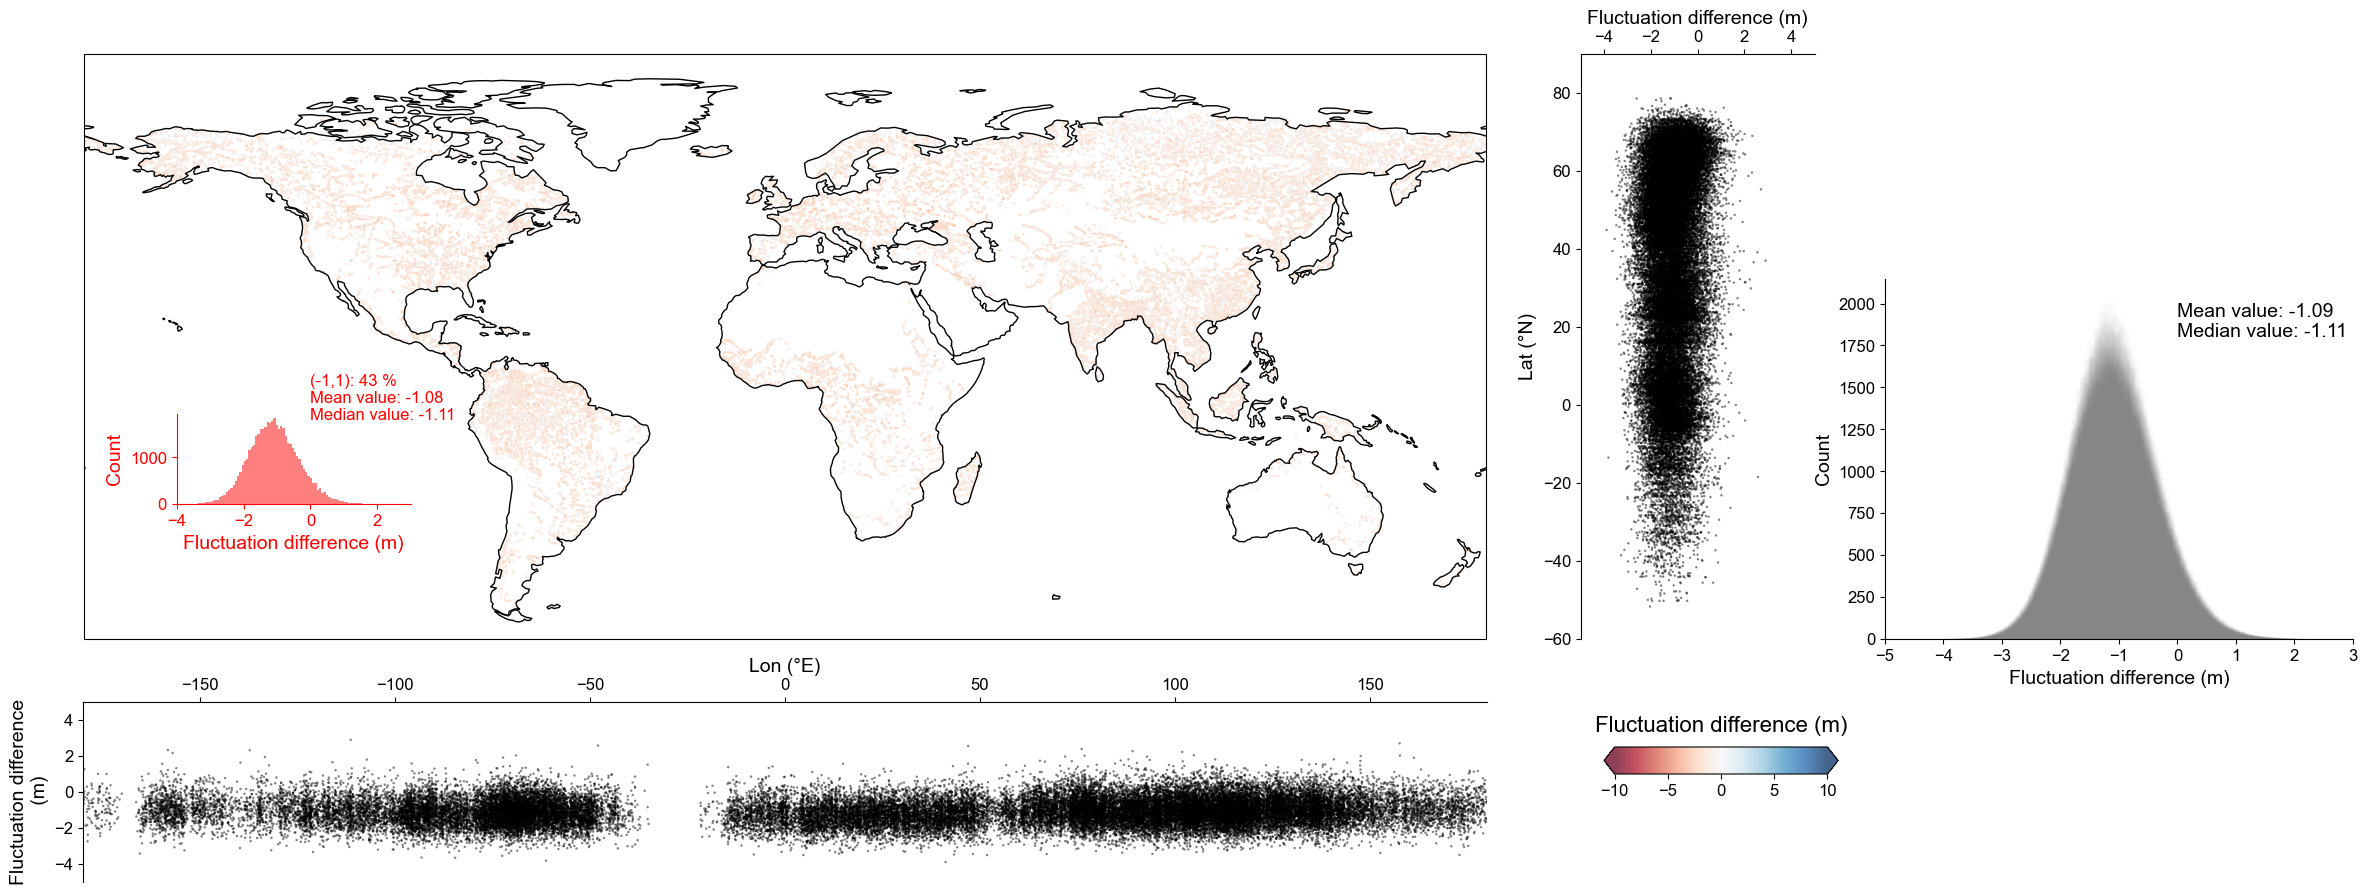

In [18]:
# Create comprehensive visualization of Monte Carlo simulation results for fluctuation analysis
# - Global map showing spatial distribution of fluctuation differences
# - Latitude and longitude profiles
# - Histogram of differences
# - Summary of all simulation iterations

lon_min=-180
lon_max=180
lat_min=-60
lat_max=90
rcParams['font.family'] = 'Arial'
fig=plt.figure(figsize=(23.4,9))

rect1=[0.05,0.25,0.6,0.65]
ax1=fig.add_axes(rect=rect1,projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()
ax1.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
sizes=3 #np.log10(widths)*3
colors=fluctuation_diff_np
china_boundary.plot(ax=ax1,color='w',alpha=1,linewidth=1)

scatter_negative = ax1.scatter(lons,
                              lats,
                              sizes,
                              colors,
                              marker='o', cmap='RdBu', alpha=0.75, vmin=-10, vmax=10,
                              edgecolors='none', transform=ccrs.PlateCarree())

rect2=[0.69,0.25,0.1,0.65]
ax2=fig.add_axes(rect=rect2)
ax2.scatter(fluctuation_diff_np,lat_np,s=sizes,c='k',alpha=0.5,edgecolors='none')
ax2.set_ylim([lat_min,lat_max])
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xlabel('Fluctuation difference (m)', fontsize=14, fontname='Arial')
ax2.set_ylabel('Lat (°N)', fontsize=14, fontname='Arial')
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)
ax2.set_xlim([-5,5])

rect3=[0.05,-0.02,0.6,0.2]
ax3=fig.add_axes(rect=rect3)
ax3.scatter(lon_np,fluctuation_diff_np,s=sizes,c='k',alpha=0.5,edgecolors='none')
ax3.set_xlim([lon_min,lon_max])
ax3.xaxis.tick_top()
ax3.xaxis.set_label_position('top')
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.invert_yaxis()
ax3.set_xlabel('Lon (°E)', fontsize=14, fontname='Arial')
ax3.set_ylabel('Fluctuation difference\n (m)', fontsize=14, fontname='Arial')
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)
ax3.set_ylim([-5,5])

rect4=[0.7,0.1,0.1,0.03]
ax4=fig.add_axes(rect=rect4)
cbar=plt.colorbar(scatter_negative,cax=ax4, shrink=0.7,orientation="horizontal",extend="both")
#cbar.locator=MultipleLocator(0.5)
cbar.set_label('Fluctuation difference (m)',fontsize=16,fontname='Arial',labelpad=-60)
cbar.ax.tick_params(labelsize=12,labelfontfamily='Arial')

rect9=[0.09,0.4,0.1,0.1]
ax9=fig.add_axes(rect=rect9)
ax9.hist(fluctuation_diff_np,bins=100,edgecolor='none',color='red',alpha=0.5)
ax9.set_ylabel('Count', fontname='Arial',fontsize=14,color='red')
ax9.set_xlabel('Fluctuation difference (m)', fontname='Arial',fontsize=14,color='red')
ax9.tick_params(labelsize=12,colors='red')
mean_value=np.mean(fluctuation_diff_np)
median_value=np.median(fluctuation_diff_np)
count10=sum(np.abs(fluctuation_diff_np)<=1)/len(fluctuation_diff_np)*100
ax9.text(0, 1800, f'(-1,1): {count10:.0f} %\nMean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='red', fontsize=12)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_color('red')
ax9.spines['bottom'].set_color('red')
ax9.set_xlim([-4,3])
ax9.set_facecolor('white')

rect=[0.82,0.25,0.2,0.4]
ax1=fig.add_axes(rect=rect)
for simulate_index in range(100):
    ax1.hist(fluctuation_test[simulate_index],bins=100,edgecolor='none',color='gray',alpha=0.01)
ax1.set_ylabel('Count', fontname='Arial',fontsize=14,color='k')
ax1.set_xlabel('Fluctuation difference (m)', fontname='Arial',fontsize=14,color='k')
ax1.tick_params(labelsize=12,colors='k')
mean_value=np.mean(fluctuation_mean_values)
median_value=np.median(fluctuation_median_values)
ax1.text(0, 1800, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='k', fontsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim([-5,3])

plt.show()

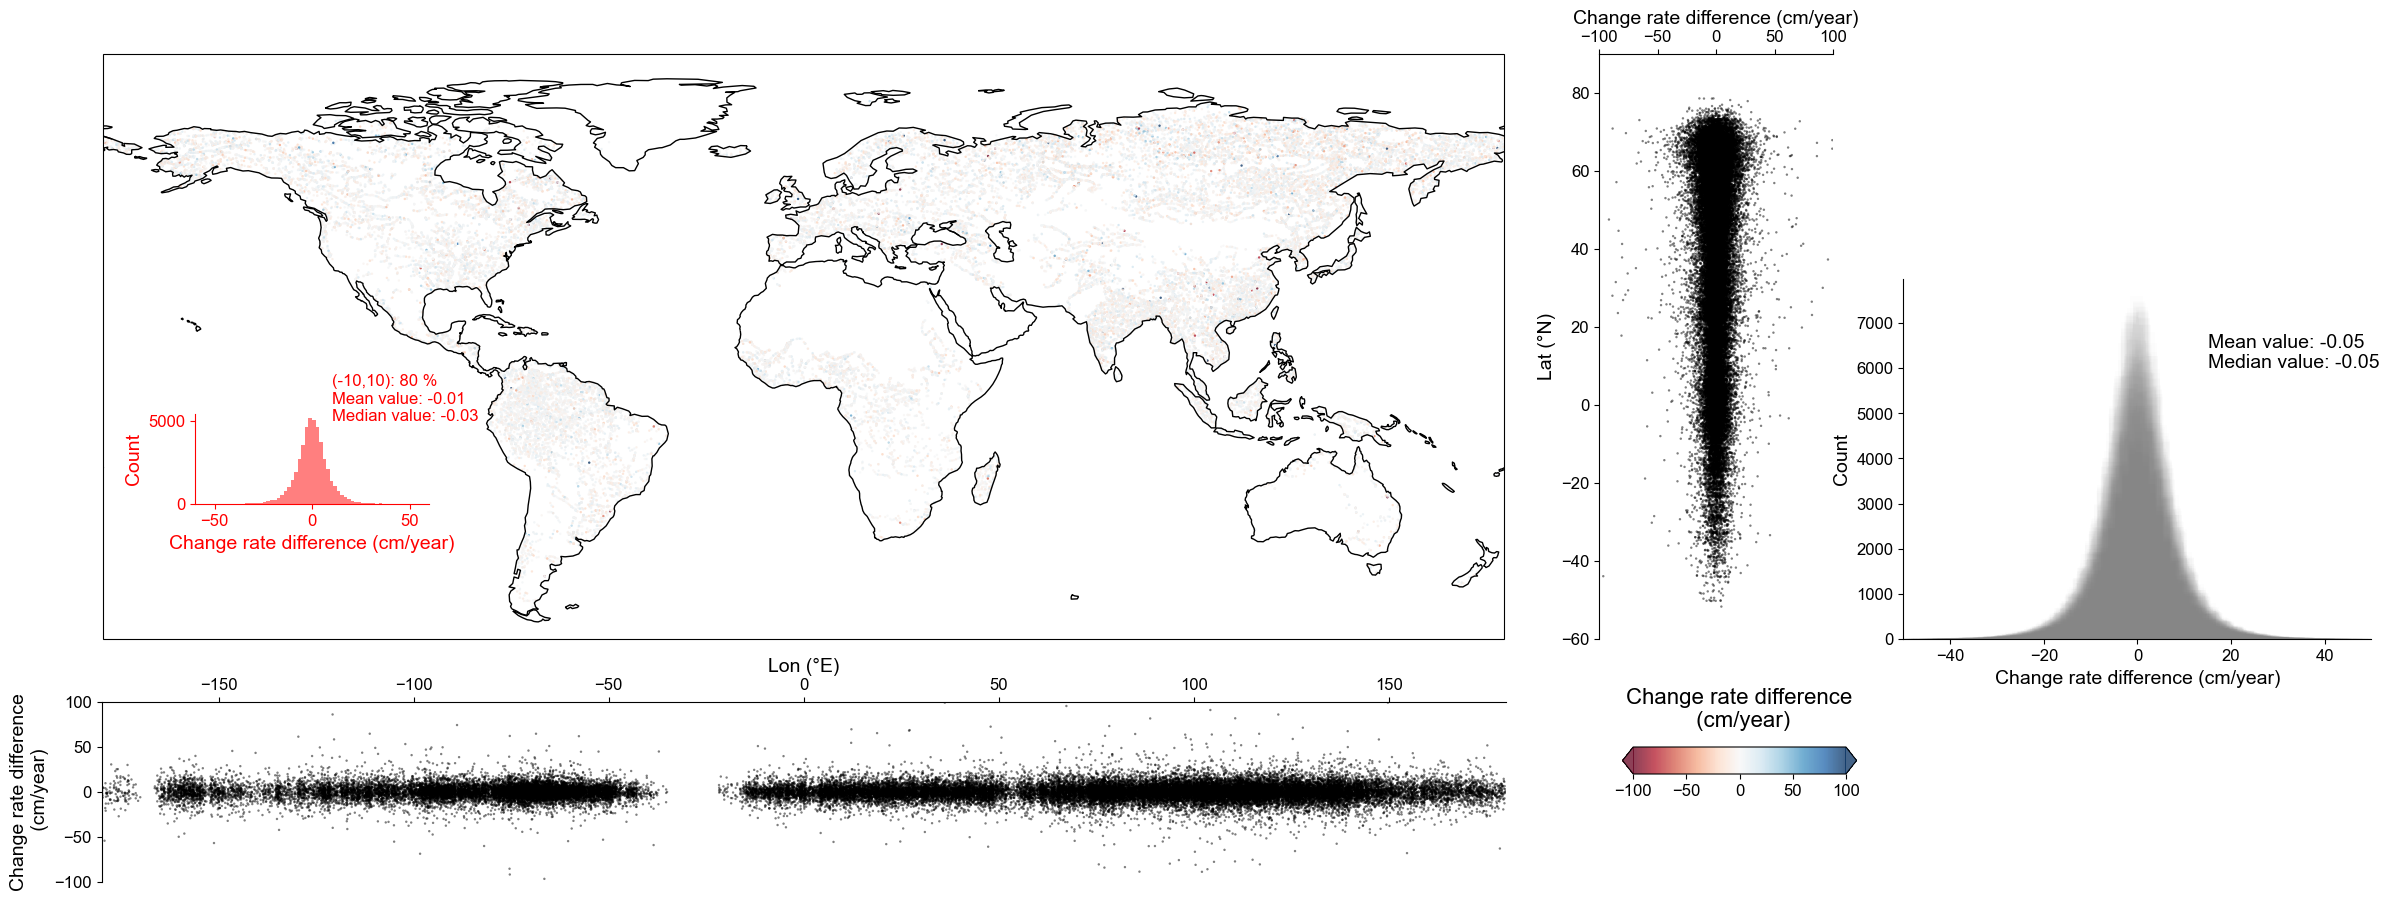

In [21]:
# Create comprehensive visualization of Monte Carlo simulation results for change rate analysis
# - Global map showing spatial distribution of change rate differences
# - Latitude and longitude profiles
# - Histogram of differences
# - Summary of all simulation iterations

lon_min=-180
lon_max=180
lat_min=-60
lat_max=90
rcParams['font.family'] = 'Arial'
fig=plt.figure(figsize=(23.4,9))

rect1=[0.05,0.25,0.6,0.65]
ax1=fig.add_axes(rect=rect1,projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()
ax1.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
sizes=3 #np.log10(widths)*3
colors=change_rate_diff_np*100
china_boundary.plot(ax=ax1,color='w',alpha=1,linewidth=1)

scatter_negative = ax1.scatter(lons,
                              lats,
                              sizes,
                              colors,
                              marker='o', cmap='RdBu', alpha=0.75, vmin=-100, vmax=100,
                              edgecolors='none', transform=ccrs.PlateCarree())

rect2=[0.69,0.25,0.1,0.65]
ax2=fig.add_axes(rect=rect2)
ax2.scatter(change_rate_diff_np*100,lat_np,s=sizes,c='k',alpha=0.5,edgecolors='none')
ax2.set_ylim([lat_min,lat_max])
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xlabel('Change rate difference (cm/year)', fontsize=14, fontname='Arial')
ax2.set_ylabel('Lat (°N)', fontsize=14, fontname='Arial')
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)
ax2.set_xlim([-100,100])

rect3=[0.05,-0.02,0.6,0.2]
ax3=fig.add_axes(rect=rect3)
ax3.scatter(lon_np,change_rate_diff_np*100,s=sizes,c='k',alpha=0.5,edgecolors='none')
ax3.set_xlim([lon_min,lon_max])
ax3.xaxis.tick_top()
ax3.xaxis.set_label_position('top')
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.invert_yaxis()
ax3.set_xlabel('Lon (°E)', fontsize=14, fontname='Arial')
ax3.set_ylabel('Change rate difference\n (cm/year)', fontsize=14, fontname='Arial')
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)
ax3.set_ylim([-100,100])

rect4=[0.7,0.1,0.1,0.03]
ax4=fig.add_axes(rect=rect4)
cbar=plt.colorbar(scatter_negative,cax=ax4, shrink=0.7,orientation="horizontal",extend="both")
#cbar.locator=MultipleLocator(0.5)
cbar.set_label('Change rate difference\n (cm/year)',fontsize=16,fontname='Arial',labelpad=-80)
cbar.ax.tick_params(labelsize=12,labelfontfamily='Arial')

rect9=[0.09,0.4,0.1,0.1]
ax9=fig.add_axes(rect=rect9)
ax9.hist(change_rate_diff_np*100,bins=1000,edgecolor='none',color='red',alpha=0.5)
ax9.set_ylabel('Count', fontname='Arial',fontsize=14,color='red')
ax9.set_xlabel('Change rate difference (cm/year)', fontname='Arial',fontsize=14,color='red')
ax9.tick_params(labelsize=12,colors='red')
mean_value=np.mean(change_rate_diff_np*100)
median_value=np.median(change_rate_diff_np*100)
count10=sum(np.abs(change_rate_diff_np*100)<=10)/len(change_rate_diff_np)*100
ax9.text(10, 5000, f'(-10,10): {count10:.0f} %\nMean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='red', fontsize=12)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_color('red')
ax9.spines['bottom'].set_color('red')
ax9.set_xlim([-60,60])
ax9.set_facecolor('white')

rect=[0.82,0.25,0.2,0.4]
ax2=fig.add_axes(rect=rect)
for simulate_index in range(100):
    ax2.hist(np.array(change_rate_test[simulate_index])*100,bins=1000,edgecolor='none',color='gray',alpha=0.01)
ax2.set_ylabel('Count', fontname='Arial',fontsize=14,color='k')
ax2.set_xlabel('Change rate difference (cm/year)', fontname='Arial',fontsize=14,color='k')
ax2.tick_params(labelsize=12,colors='k')
mean_value=np.mean(np.array(change_mean_values)*100)
median_value=np.median(np.array(change_median_values)*100)
ax2.text(15, 6000, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='k', fontsize=14)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim([-50,50])

plt.show()

In [22]:
#Save the figure in PDF format
ouput_name=r'changerate_diff.pdf'
fig.savefig(ouput_name, bbox_inches='tight', bbox_extra_artists=(ax2,))

In [23]:
#Load hydrological basins
basin_path='../Post processing/Major_hydrological_basins/major_hydrobasins.shp'
Major_basins=gpd.read_file(basin_path)
Major_basins

,MAJ_BAS,MAJ_NAME,MAJ_AREA,geometry
0,4050,Arctic Ocean Islands,2166086,"POLYGON ((-28.65000 83.43750, -28.67500 83.437..."
1,4050,Arctic Ocean Islands,2166086,"POLYGON ((-41.15417 83.33750, -41.19583 83.337..."
2,4050,Arctic Ocean Islands,2166086,"POLYGON ((-41.28750 83.28750, -41.34167 83.287..."
3,4050,Arctic Ocean Islands,2166086,"POLYGON ((-39.06667 83.28750, -39.25417 83.287..."
4,4050,Arctic Ocean Islands,2166086,"POLYGON ((-43.39583 83.25000, -43.67917 83.250..."
...,...,...,...,...
28144,9001,Antarctica,0,"POLYGON ((-149.98750 -77.51667, -149.99167 -77..."
28145,9001,Antarctica,0,"POLYGON ((167.28751 -78.30417, 167.28334 -78.3..."
28146,9001,Antarctica,0,"POLYGON ((166.22501 -78.35000, 166.22084 -78.3..."
28147,9001,Antarctica,0,"POLYGON ((-65.48333 -78.42083, -65.48750 -78.4..."


<Axes: >

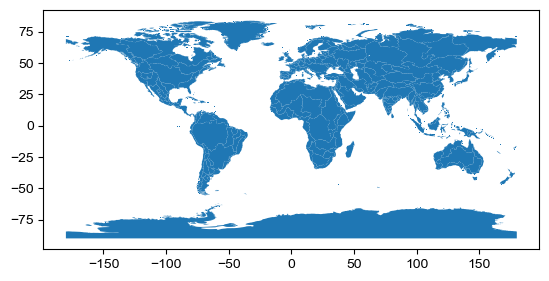

In [24]:
#Plot global basins
china_basins=Major_basins
china_basins.plot()

In [25]:
# Extract unique basin names and IDs
Basin_names=china_basins['MAJ_NAME'].to_list()
Basin_IDs=china_basins['MAJ_BAS'].to_list()
Basin_name_unique=[]
Basin_ID_unique=[]
Basin_ID_unique=list(set(Basin_IDs))
Basin_name_unique=list(set(Basin_names))

In [27]:
# Perform basin-level Monte Carlo simulation analysis
# - Uses parallel processing for efficiency
# - Simulates measurement uncertainties for each basin

import multiprocessing as mp
from tqdm.notebook import tqdm
import warnings
from Monte_Carlo_basin import process_single_basin,init_worker
warnings.filterwarnings('ignore')

# Initialize global variables for sharing across processes
global_vars = None

#  Prepare shared data for parallel processing
shared_data = {
    'Basin_IDs': Basin_IDs,
    'china_basins': china_basins,   # Basin attributes
    'meas_error': meas_error,    # Measurement error
    'new_dataset': new_dataset   # Water level dataset
}

# Configure parallel processing
n_processes = max(1, 6) # Reserve one core for system

# Initialize result collection lists
Basin_collect_name = []
Basin_collect_fluctuation_test = []# Simulated fluctuations
Basin_collect_change_rate_test = []# Simulated change rates
Basin_collect_fluctuation_raw = []# Original fluctuations
Basin_collect_change_rate_raw = []# Original change rates

# Execute parallel processing
try:
    with mp.Pool(processes=n_processes, initializer=init_worker, initargs=(shared_data,)) as pool:
        results = list(tqdm(
            pool.imap(process_single_basin, Basin_ID_unique),
            total=len(Basin_ID_unique),
            desc="Processing basins"
        ))
except Exception as e:
    print(f"Error in parallel processing: {str(e)}")
    results = []

# Collect and organize results
for result in results:
    if result is not None:
        Basin_collect_name.append(result['basin_name'])
        Basin_collect_fluctuation_test.append(result['fluctuation_sim'])
        Basin_collect_change_rate_test.append(result['change_rate_sim'])
        Basin_collect_fluctuation_raw.append(result['fluctuation_raw'])
        Basin_collect_change_rate_raw.append(result['change_rate_raw'])

print(f"Processing complete! Analyzed {len(Basin_collect_name)} basins.")

Processing basins:   0%|          | 0/231 [00:00<?, ?it/s]

处理完成！共得到了 137 个流域。


In [45]:
from shapely.ops import unary_union
rcParams['font.family'] = 'Arial'
# Create GeoDataFrame with Monte Carlo simulation results at basin level
# - Combines basin geometries with simulation statistics
# - Calculates difference metrics and relative errors

collected_basins = gpd.GeoDataFrame(columns=china_basins.columns.tolist() + ['fluctuation_test',# Simulated fluctuations
                                                                             'change_rate_test',# Simulated change rates
                                                                            'merged_fluctuation',# Original fluctuations
                                                                            'merged_change_rate',# Original change rates
                                                                            'median_fluctuation_diff',# Median fluctuation difference
                                                                            'median_changerate_diff',# Median change rate difference
                                                                            'flu_diff/raw',# Relative fluctuation error (%)
                                                                            'change_diff/raw'])# Relative change rate error (%)

for i in range(len(Basin_collect_name)):
    selected_basins=china_basins[china_basins['MAJ_NAME']==Basin_collect_name[i]]
    combined_geometry = unary_union(selected_basins.geometry)
     # Add simulation results
    new_record = selected_basins.iloc[0].copy()
    new_record.geometry = combined_geometry
    new_record['fluctuation_test'] = Basin_collect_fluctuation_test[i]
    new_record['change_rate_test'] = Basin_collect_change_rate_test[i]
    new_record['merged_fluctuation'] = Basin_collect_fluctuation_raw[i]
    new_record['merged_change_rate'] = Basin_collect_change_rate_raw[i]
    # Calculate differences and relative errors
    flu_diff=Basin_collect_fluctuation_raw[i]-np.array(Basin_collect_fluctuation_test[i])
    change_rate_diff=Basin_collect_change_rate_raw[i]-np.array(Basin_collect_change_rate_test[i])

    new_record['median_fluctuation_diff'] = np.median(flu_diff)
    new_record['median_changerate_diff'] = np.median(change_rate_diff)
    new_record['flu_diff/raw']=abs(np.median(flu_diff)/Basin_collect_fluctuation_raw[i])*100
    new_record['change_diff/raw']=abs(np.median(change_rate_diff)/Basin_collect_change_rate_raw[i])*100
    # Add record to collection
    collected_basins = pd.concat([collected_basins, gpd.GeoDataFrame([new_record])], ignore_index=True)


In [47]:
# Convert change rate differences from m/yr to cm/yr
collected_basins['median_changerate_diff']=collected_basins['median_changerate_diff']*100#->cm/yr
collected_basins2=collected_basins

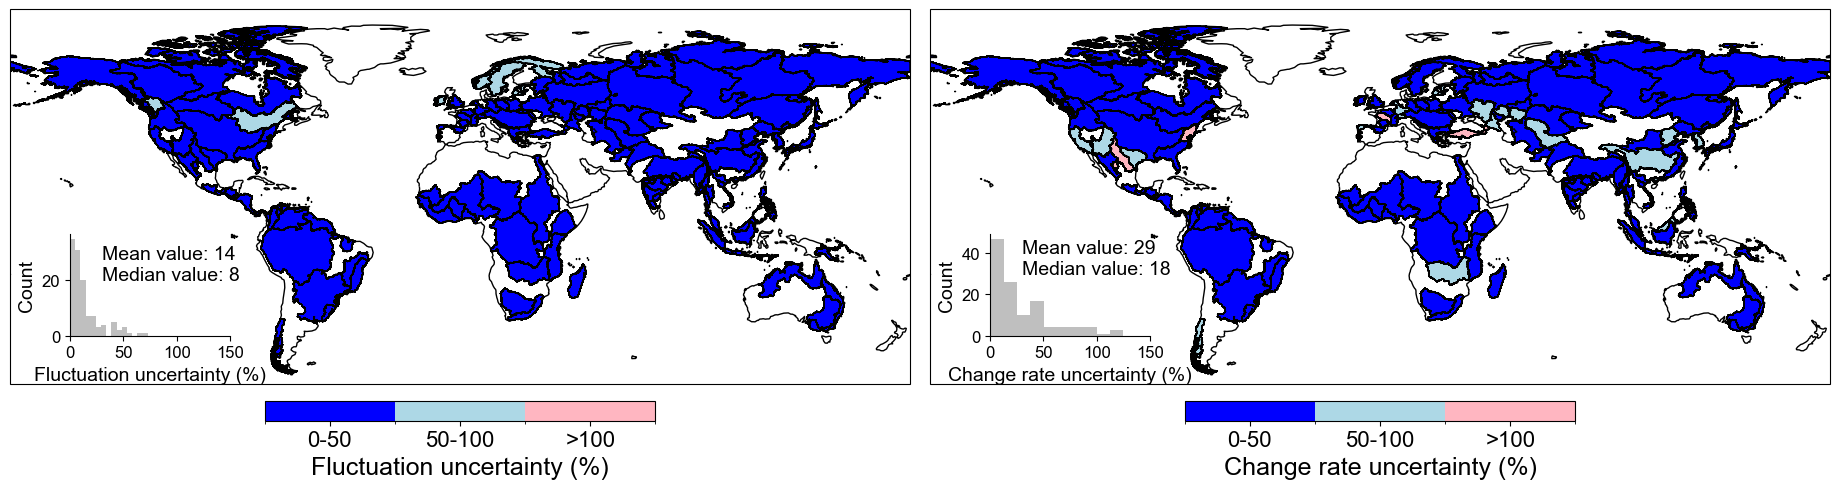

In [67]:
# Create comprehensive visualization of basin-level uncertainty analysis
# - Maps showing spatial distribution of uncertainties
# - Histograms of uncertainty distributions
# - Custom color scheme for uncertainty ranges

import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as colors
rcParams['font.family'] = 'Arial'
lon_min=-180
lon_max=180
lat_min=-60
lat_max=90
fig=plt.figure(figsize=(20,17))

colors_list = ['#0000FF',  # Deep blue for [0, 50]
              '#ADD8E6',   # Light blue for [50, 100]
              '#FFB6C1']   # Light red for [>100]
bounds = [0, 50, 100, 200]
norm=colors.BoundaryNorm(bounds, len(colors_list))
cmap = colors.ListedColormap(colors_list)

rect1=[0.05,0.7,0.45,0.25]
ax1=fig.add_axes(rect=rect1,projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()
ax1.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
plot1=collected_basins2.plot(ax=ax1,column='flu_diff/raw', cmap=cmap, norm=norm, legend=False,edgecolor='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar1 = plt.colorbar(sm, ax=ax1, orientation='horizontal',boundaries=bounds, fraction=0.046, pad=0.04, ticks=[25, 75, 150])
cbar1.set_ticklabels(['0-50', '50-100', '>100'])
cbar1.set_label('Fluctuation uncertainty (%)',fontsize=18)
cbar1.ax.tick_params(labelsize=16)
#cbar1.ax.set_xlim([0,150])

flu_uncertainty=collected_basins2['flu_diff/raw'].tolist()
rect=[0.08,0.75,0.08,0.06]
ax=fig.add_axes(rect=rect)
ax.hist(flu_uncertainty,bins=15,edgecolor='none',color='gray',alpha=0.5)
ax.set_ylabel('Count', fontname='Arial',fontsize=14,color='k')
ax.set_xlabel('Fluctuation uncertainty (%)', fontname='Arial',fontsize=14,color='k')
ax.tick_params(labelsize=12,colors='k')
mean_value=np.mean(np.array(flu_uncertainty))
median_value=np.median(np.array(flu_uncertainty))
ax.text(30, 20, f'Mean value: {mean_value:.0f}\nMedian value: {median_value:.0f}', fontname='Arial', color='k', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,150])
ax.set_facecolor('None')


rect2=[0.51,0.7,0.45,0.25]
ax2=fig.add_axes(rect=rect2,projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_global()
ax2.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
collected_basins2.plot(ax=ax2,column='change_diff/raw', cmap=cmap, norm=norm, legend=False,edgecolor='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = [] 
cbar2 = plt.colorbar(sm, ax=ax2, orientation='horizontal',boundaries=bounds, fraction=0.046, pad=0.04, ticks=[25, 75, 150])
cbar2.set_ticklabels(['0-50', '50-100', '>100'])
cbar2.set_label('Change rate uncertainty (%)',fontsize=18)
cbar2.ax.tick_params(labelsize=16)
#cbar2.ax.set_xlim([0,150])

changerate_uncentainty=collected_basins2['change_diff/raw'].tolist()
rect=[0.54,0.75,0.08,0.06]
ax3=fig.add_axes(rect=rect)
ax3.hist(changerate_uncentainty,bins=10,edgecolor='none',color='gray',alpha=0.5)
ax3.set_ylabel('Count', fontname='Arial',fontsize=14,color='k')
ax3.set_xlabel('Change rate uncertainty (%)', fontname='Arial',fontsize=14,color='k')
ax3.tick_params(labelsize=12,colors='k')
mean_value=np.mean(np.array(changerate_uncentainty))
median_value=np.median(np.array(changerate_uncentainty))
ax3.text(30, 30, f'Mean value: {mean_value:.0f}\nMedian value: {median_value:.0f}', fontname='Arial', color='k', fontsize=14)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_xlim([0,150])
ax3.set_facecolor('None')

plt.tight_layout()
plt.show()

In [68]:
#Save the figure in PDF format
ouput_name=r'flu_change_diff_basin_compr_raw2.pdf'
fig.savefig(ouput_name, bbox_inches='tight', bbox_extra_artists=(ax2,))